The objective of this file is to explore two options for producing a chart in an Excel workbook using `openpyxl`.

Import the relevant modules and files:

In [1]:
import pandas as pd
import seaborn as sns
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.chart import BarChart, Reference
from openpyxl.drawing.image import Image

contestants = pd.read_excel('contestants_cleaned.xlsx')
contestants.head()

,email,cohort,pre,post,age,sex,education,satisfaction,study_hours
0,smehaffey0@creativecommons.org,4,485,494,32,Male,Bachelor's,2,36.6
1,bbenham2@xrea.com,3,477,483,33,Female,Bachelor's,1,19.8
2,jagostini4@wordpress.org,1,495,494,38,Female,Bachelor's,9,32.5
3,kbridgnell5@webnode.com,1,484,503,32,Female,Bachelor's,6,32.2
4,abotham6@usda.gov,1,497,501,30,Female,Bachelor's,10,32.3


# Option A: Write an Excel plot

Excel's data visualization features are popular because they are easy to use and effective. Let's explore how to create native Excel charts from Python using `openpyxl`.

## Creating the raw data source 

To plot data in Excel from Python, we must first write the data to an Excel workbook. Let's begin by generating the necessary data source using the `value_counts()` function. We'll use this data to create a basic plot visualizing the number of observations in each cohort.

In [2]:
cohort_count = contestants['cohort'].value_counts().reset_index()
cohort_count

,index,cohort
0,1,23
1,3,21
2,4,20
3,2,18


The `reset_index()` function is used in the previous code block to reset the resulting DataFrame back to its original index. To make this DataFrame more readable, let's rename the columns to `cohort` and `count`, respectively: 

In [3]:
cohort_count = cohort_count.rename(columns={'index':'cohort', 'cohort':'count'})
cohort_count

,cohort,count
0,1,23
1,3,21
2,4,20
3,2,18


Now that we have it summarized exactly as we want it to be plotted, let's transfer the data to Excel.

## Exporting the data to Excel

Next, we'll initialize a workbook and active worksheet, saving these as `workbook` and `worksheet` respectively. We can also name the worksheet `date` using the `title` attribute. 

In [4]:
# Create a new Workbook
workbook = Workbook()

# Get the active worksheet
worksheet = workbook.active

# Name the worksheet as "data"
worksheet.title = "data"

To transfer the `cohort_count` DataFrame over to this worksheet, we'll use [`dataframe_to_rows()`](https://stringfestanalytics.com/how-to-write-a-pandas-dataframe-to-an-excel-table-using-openpyxl/) along with a loop: 

In [5]:
# Write the DataFrame to the worksheet
for row in dataframe_to_rows(cohort_count, index=False, header=True):
    worksheet.append(row)

## Getting the dimensions of the data

After writing the data to Excel, we need to reference the specific range for plotting. It's important to note that base Python uses [zero-based indexing](https://stringfestanalytics.com/seen-zero-based-indexing/), while Excel and `openpyxl` use one-based indexing, which adds a bit of complexity here.

In the following code block, we determine the total number of rows in the DataFrame and find the index positions of the `cohort` and `count` columns. These values will be crucial in accurately referencing the desired data range for plotting purposes.

In [6]:
total_rows = len(cohort_count) + 1
category_col = cohort_count.columns.get_loc('cohort') + 1
value_col = cohort_count.columns.get_loc('count') + 1

## Creating the bar chart

With the data and ranges defined, we can now proceed to insert the plot. The following block will specify the plot type, set a title, and define the active ranges for the bar chart:

In [7]:
chart = BarChart()
chart.title = "Number of participants by cohort"

categories = Reference(worksheet, min_col=category_col, min_row=2, max_row=total_rows)
values = Reference(worksheet, min_col=value_col, min_row=1, max_row=total_rows)

chart.add_data(values, titles_from_data=True)
chart.set_categories(categories)

## Saving and closing

We can now specify the plot's placement within the workbook and save the workbook to finalize the changes.

In [8]:
worksheet.add_chart(chart, "E1")
workbook.save("openpyxl-viz.xlsx")

# Option 2: Create a Python visualization

Python has advantages in data visualization over Excel, as Excel lacks certain types of visualizations and customizing plots is generally easier in Python. But even though it's possible to insert Python plots into Excel, they lack the interactive functionality that users may expect, as they are rendered as static images.

## Creating a pairplot

Excel lacks an out-of-the-box solution for analyzing the relationships between multiple variables simultaneously. However, the `seaborn` data visualization package provides the `pairplot()` function for a quick and convenient exploration. 

The following block visualizes these relationships across the selected variables of `contestants`: 

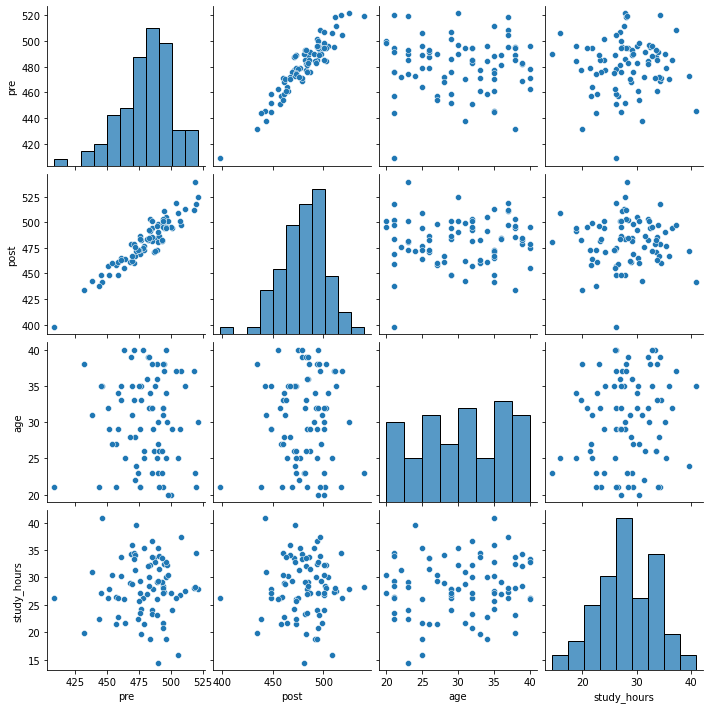

In [9]:
sns.pairplot(contestants[['pre', 'post', 'age', 'study_hours']])

Next, we'll include the `sex` column in our variable selection and set it as the `hue` parameter.

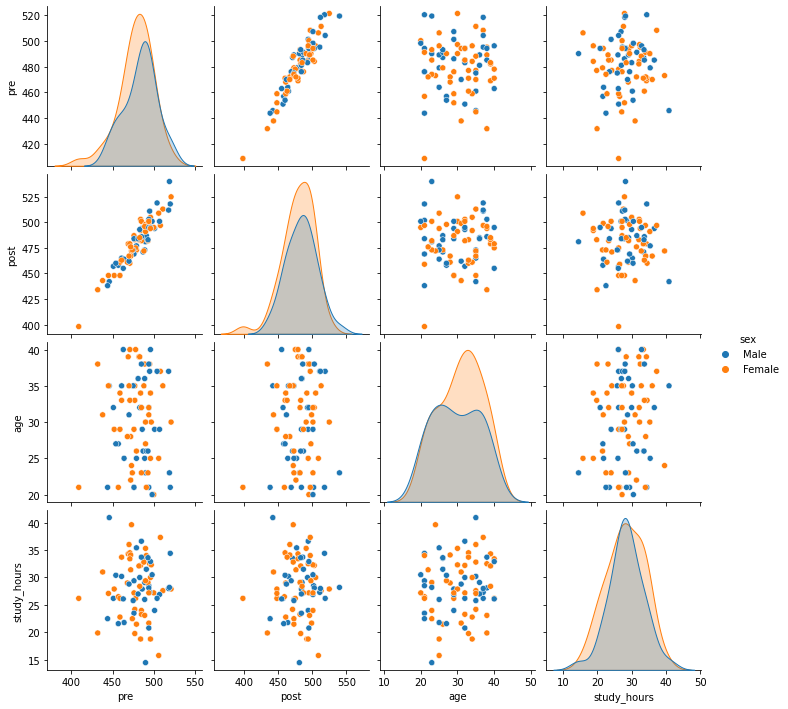

In [10]:
sns_plot = sns.pairplot(contestants[['pre', 'post', 'age', 'study_hours', 'sex']],
            hue='sex')

## Add the image to Excel

After creating the pairplot in Python, we can export it to Excel as a static image. While there is no need to include the underlying data in Excel, we do need to specify where to place the image -- in this case, a new worksheet called `pairplot`: 

In [11]:
# Create new worksheet 
worksheet_2 = workbook.create_sheet('pairplot')

First, we'll save a copy of the previously-created pairplot as `pairplot.png`. Then we'll insert it into cell `A1` of the designated worksheet: 

In [12]:
# Save last created viz as an image
sns_plot.savefig('pairplot.png')

# Load saved image into the worksheet
image = Image('pairplot.png')
worksheet_2.add_image(image, 'A1')

Finally, we can resave our `openpyxl-viz.xlsx` workbook and close the connection: 

In [13]:
workbook.save('openpyxl-viz.xlsx')
workbook.close()